In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = (15.0, 7.0)

In [2]:
data_filenames=['p0.out', 'p1.out']
raw_data = [{},{}]
pir_type = ""
N, n, local_time, mpc_time, total_time = 0, 0, 0., 0., 0.
for p in range(2):
    with open(data_filenames[0]) as f:
        for line in f.read().splitlines():
            fields = line.split()
            if fields[0] == "PIR":
                pir_type = fields[-1]
                raw_data[p][pir_type] = []
            if fields[0] == "num_elements_server:":
                N = fields[-1]
            if fields[0] == "num_elements_client:":
                n = fields[-1]
            if fields[0] == "local_time:":
                local_time = fields[-2]
            if fields[0] == "mpc_time:":
                mpc_time = fields[-2]
            if fields[0] == "total_time:":
                total_time = fields[-2]
                raw_data[p][pir_type] += \
                    [[N, n, local_time, mpc_time, total_time]]
            
data = [{k : np.array(raw[k], dtype = np.float64) 
        for k in raw.keys()} for raw in raw_data]

# data always is (n, N)
# TODO: this should really be generated from the asymptotic parts
f_default = lambda data,a,b,c,d: a * data[:,0] * data[:,1] + \
            b * data[:,0] + c * data[:,1] + d
f_local = [
    { # server
        'fss': f_default,
        'scs': f_default,
        'poly': lambda data,a,b,c,d: 
            a * np.log2(data[:,1]) * data[:,1] + \
            b * np.log2(data[:,1]) + c * data[:,1] + d
    }, 
    { # client
        'fss': f_default,
        'scs': f_default,
        'poly': f_default
    },
]
f_mpc = { # same for both parties
    'fss': lambda data,a,b,c,d,e,f: (a*data[:,1] + \
        b*data[:,1]*np.log2(data[:,1]) + c *np.log2(data[:,1]) + d) * \
        (e*data[:,0] + f),
    'scs': lambda data,a,b,c,d: [a*n + b*n*np.log2(n) + \
        d #c*n*(np.log2(n)**2) + d
            for n in [data[:,0] + data[:,1]]][0], # wow, this is hacky
    'poly': f_default
}

params_local = [
    {
        k : curve_fit(f_local[p][k], data[p][k][:,:2], data[p][k][:,2])[0]
        for k in data[p].keys()
    } for p in range(2)
]
params_mpc = [
    {
        k : curve_fit(f_mpc[k], data[p][k][:,:2], data[p][k][:,3])[0]
        for k in data[p].keys()
    } for p in range(2)
]
params_total = [
    {
        k : curve_fit(f_mpc[k], data[p][k][:,:2], data[p][k][:,4])[0]
        for k in data[p].keys()
    } for p in range(2)
]
print("params_local =", params_local)
print("params_mpc =", params_mpc)

def model(setting, p, algo):
    if setting == 'local':
        return lambda data: f_local[p][algo](data, *(params_local[p][algo]))
    if setting == 'mpc':
        return lambda data: f_mpc[algo](data, *(params_mpc[p][algo]))
    if setting == 'local + mpc':
        return lambda data: model('local', p, algo)(data) + model('mpc', p, algo)(data)
    return None

params_local = [{'fss': array([-1.68065974e-11,  4.48023275e-07, -1.30060692e-06,  5.62575455e-01]), 'scs': array([-1.50631279e-13,  8.52799546e-08,  5.01786885e-08,  1.37469213e-04]), 'poly': array([ 1.79273322e-06, -4.29201331e-03, -2.42094346e-05,  1.98016422e+00])}, {'fss': array([-1.68065974e-11,  4.48023275e-07, -1.30060692e-06,  5.62575455e-01]), 'scs': array([-1.50631279e-13,  8.52799546e-08,  5.01786885e-08,  1.37469213e-04]), 'poly': array([-3.37970015e-10,  7.43783535e-05,  2.64841046e-06, -9.54737206e-02])}]
params_mpc = [{'fss': array([1.71959498e-05, 3.09942643e-08, 1.07347611e-05, 3.43937302e-04,
       4.47054556e-03, 1.08298625e+03]), 'scs': array([7.35531662e-04, 5.16895657e-05, 1.00000000e+00, 8.24543931e-01]), 'poly': array([-9.04956572e-11,  8.82780660e-07,  2.29643287e-03,  2.55185693e-01])}, {'fss': array([1.71959498e-05, 3.09942643e-08, 1.07347611e-05, 3.43937302e-04,
       4.47054556e-03, 1.08298625e+03]), 'scs': array([7.35531662e-04, 5.16895657e-05, 1.000000

/usr/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


========== ('local + mpc', 'Server') ==========


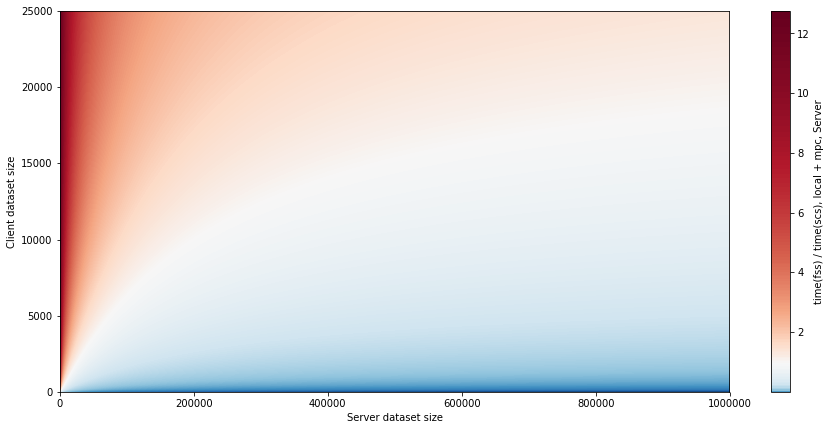

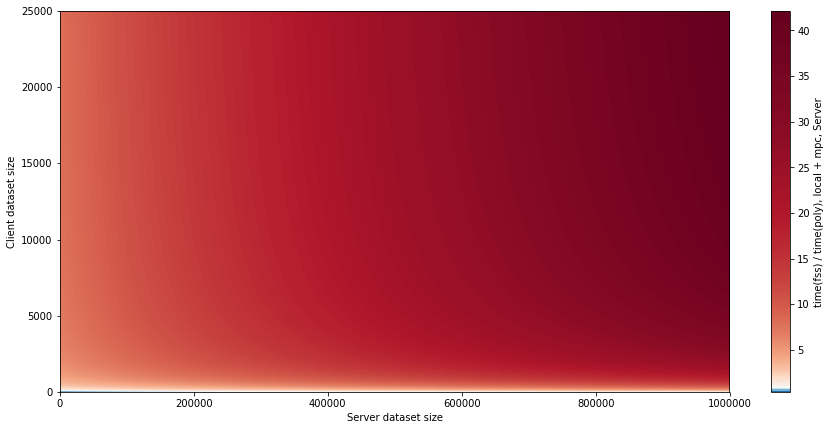

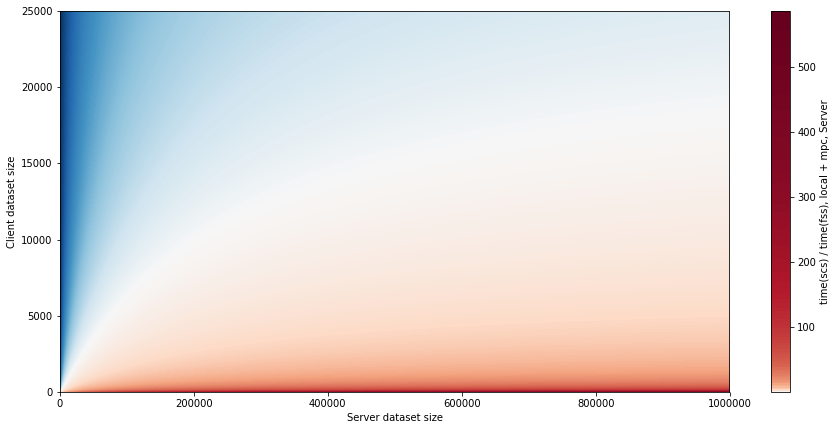

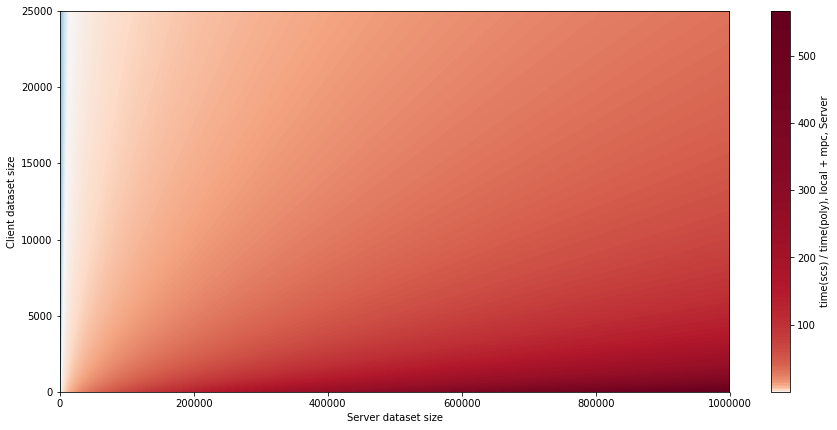

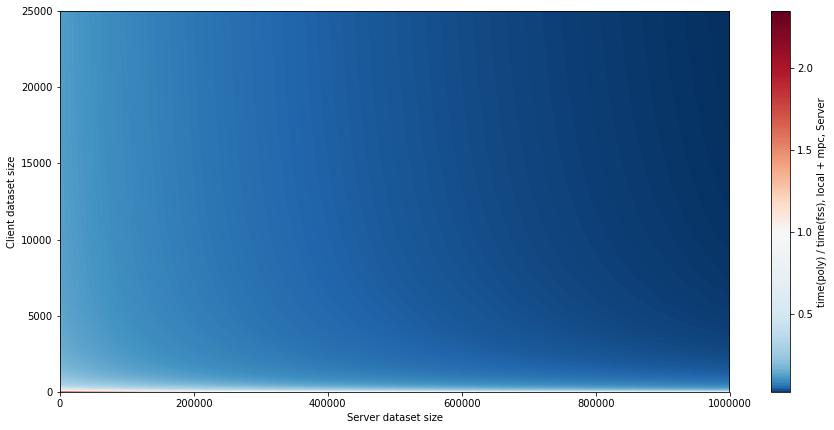

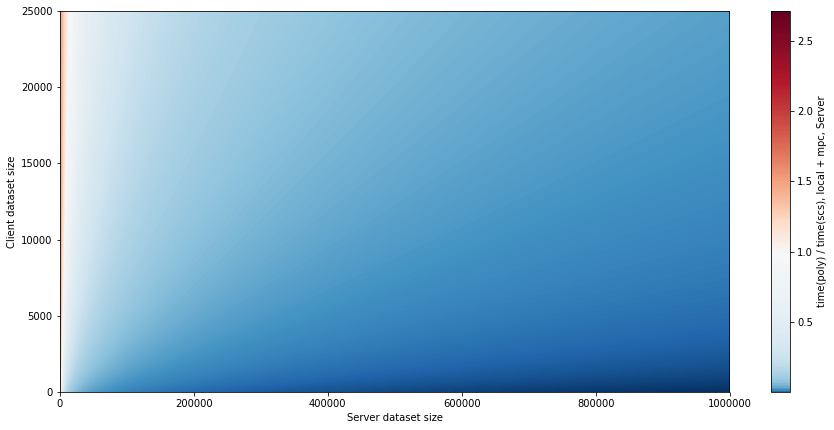

========== ('local + mpc', 'Client') ==========


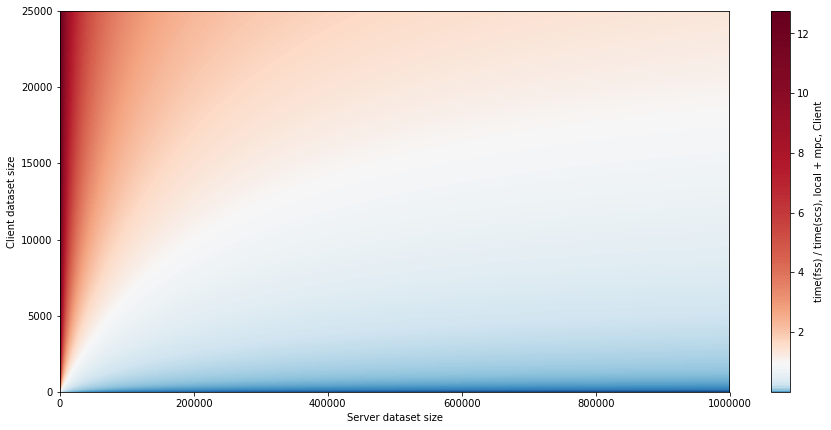

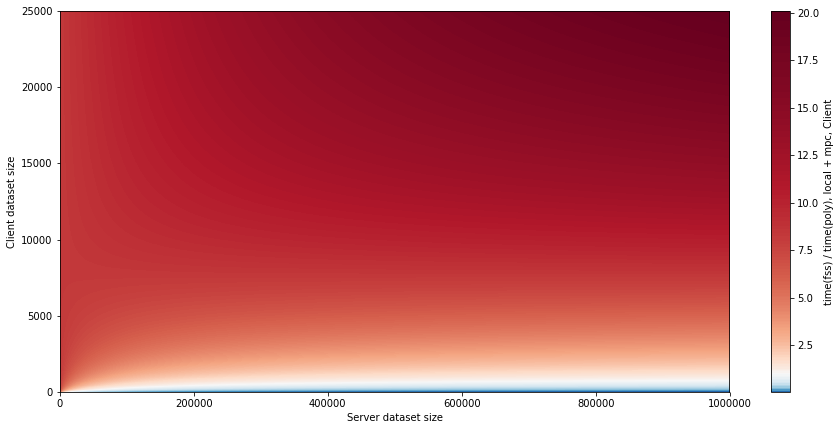

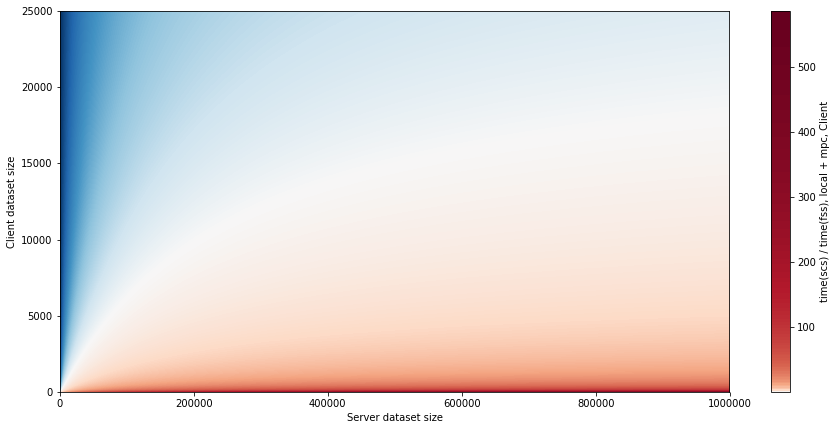

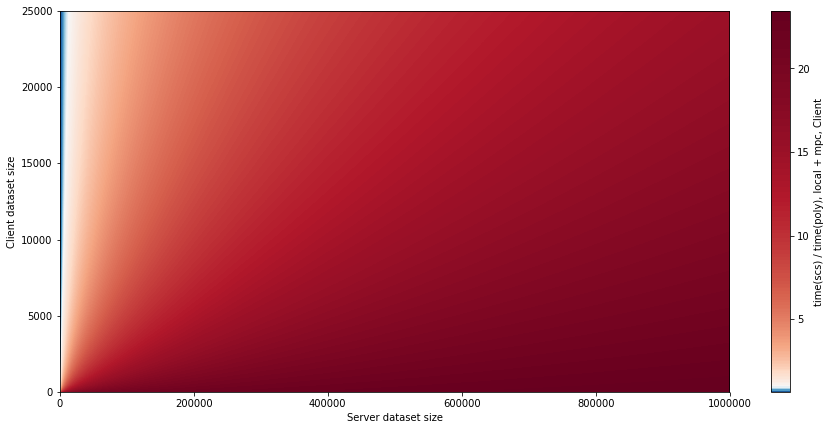

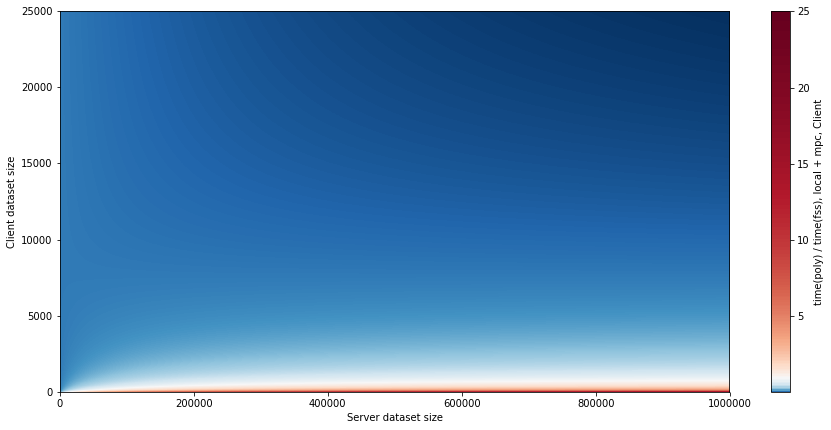

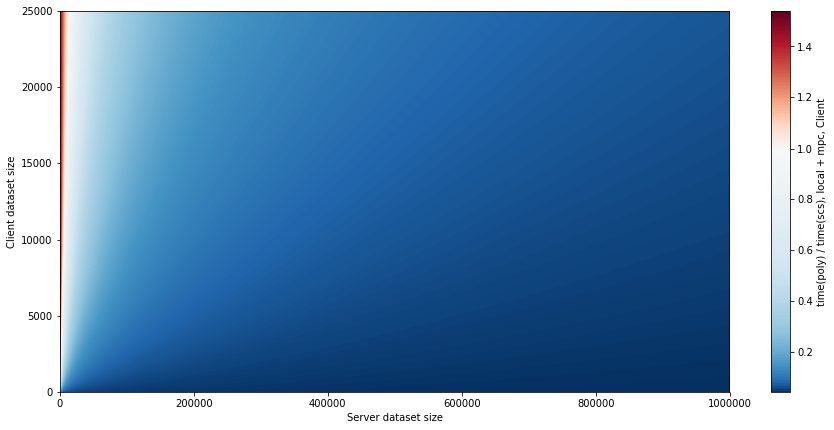

In [3]:
from scipy.interpolate import griddata
from matplotlib import colors
import itertools

client_min = 1
server_min = 1
client_max = 2.5e4
server_max = 1e6
server_sizes = np.arange(server_min, server_max+1, server_max/2000)
client_sizes = np.arange(client_min, client_max+1, client_max/2000)

def cartesian_product(x, y):
    # https://stackoverflow.com/q/11144513
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

# https://matplotlib.org/tutorials/colors/colormapnorms.html
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), np.log(x), y))
        #return np.ma.masked_array(np.interp(value, x, y))
        #return np.ma.masked_array(np.interp(
        #    np.power(np.array(value),0.5), np.power(np.array(x),0.5), y))

sizes = cartesian_product(server_sizes, client_sizes)
#settings = ['mpc', 'local'] # TODO: put this somewhere earlier
settings = ['local + mpc']
last = ("", "")
for setting, p, algo1, algo2 in itertools.product(
    settings, range(2), data[0].keys(), data[0].keys()
):
    p_name = "Server" if p == 0 else "Client"
    if (setting, p_name) != last:
        last = (setting, p_name)
        print('========== {} =========='.format(last))
    if algo1 == algo2: continue
    model1 = model(setting, p, algo1)
    model2 = model(setting, p, algo2)
    
    times_algo1 = np.maximum(0, model1(sizes))
    times_algo2 = np.maximum(0, model2(sizes))

    z = (times_algo1 / times_algo2).reshape((len(client_sizes), len(server_sizes))) # x-axis is inner dimension for imshow

    plt.imshow(z, origin='lower', aspect="auto", 
               norm=MidpointNormalize(midpoint=1.), cmap='RdBu_r',
               extent=(server_min, server_max, client_min, client_max))
    cb = plt.colorbar()
    cb.set_label('time({}) / time({}), {}, {}'.format(
        algo1, algo2, setting, p_name))
    plt.xlim((min(server_sizes), max(server_sizes)))
    plt.ylim((min(client_sizes), max(client_sizes)))

    plt.xlabel("Server dataset size")
    plt.ylabel("Client dataset size")
    #plt.savefig('benchmarks.pdf', bbox_inches='tight')
    plt.show()

========== Best algorithm ==========


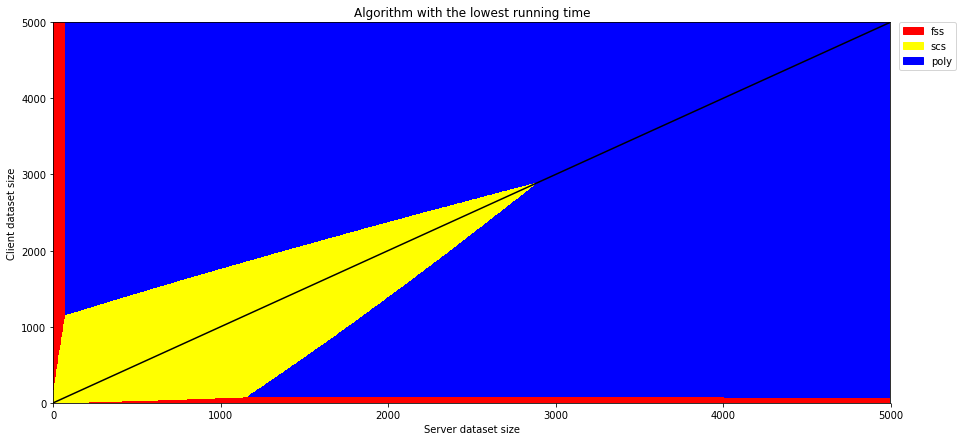

In [4]:
from scipy.interpolate import griddata
import matplotlib.patches as mpatches
from matplotlib import colors
import itertools

client_min = 1
server_min = 1
client_max = 5000
server_max = 5000
server_sizes = np.arange(server_min, server_max+1, server_max/2000)
client_sizes = np.arange(client_min, client_max+1, client_max/2000)

sizes = cartesian_product(server_sizes, client_sizes)
#settings = ['mpc', 'local'] # TODO: put this somewhere earlier

print('========== {} =========='.format("Best algorithm"))
algos = ['fss', 'scs', 'poly']
setting = 'local + mpc'
times = np.array([model(setting, 0, algo)(sizes) for algo in algos])
z1 = np.array([a.reshape((len(client_sizes), len(server_sizes))) for a in times])
z = np.argmin(np.minimum(z1, np.swapaxes(z1, 1, 2)), axis=0)


# make a color map of fixed colors
cmap = colors.ListedColormap(['red', 'yellow', 'blue'])#(['red', 'green', 'blue'])
bounds=[0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

#z = best.reshape((len(client_sizes), len(server_sizes)))
im = plt.imshow(z, origin='lower', aspect="auto", cmap=cmap, norm=norm,
           extent=(server_min, server_max, client_min, client_max))
plt.plot(server_sizes, server_sizes, 'black', label='client = server')

colors = [ im.cmap(im.norm(value)) for value in [0,1,2]]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=algos[i]) ) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0. )


plt.xlim((min(server_sizes), max(server_sizes)))
plt.ylim((min(client_sizes), max(client_sizes)))

plt.xlabel("Server dataset size")
plt.ylabel("Client dataset size")
plt.title("Algorithm with the lowest running time")

plt.show()

========== Best algorithm ==========


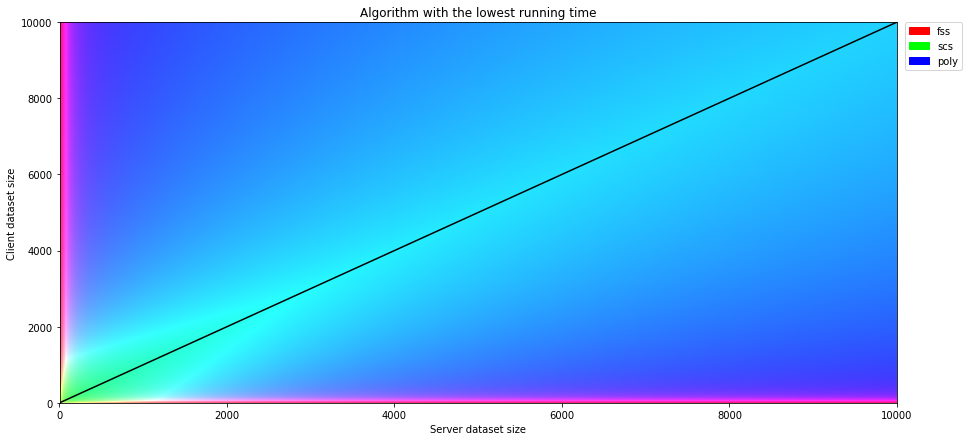

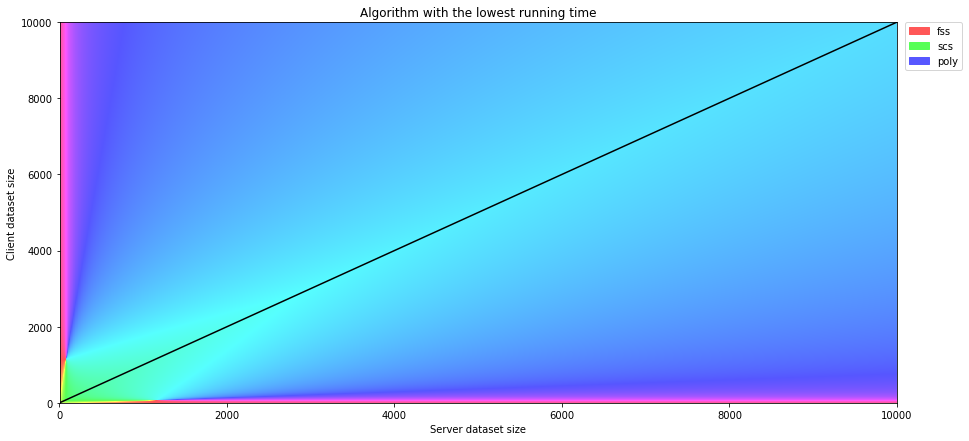

In [5]:
from scipy.interpolate import griddata
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib
import itertools

client_min = 1
server_min = 1
client_max = 10000
server_max = 10000
server_sizes = np.arange(server_min, server_max+1, server_max/2000)
client_sizes = np.arange(client_min, client_max+1, client_max/2000)

sizes = cartesian_product(server_sizes, client_sizes)
#settings = ['mpc', 'local'] # TODO: put this somewhere earlier

print('========== {} =========='.format("Best algorithm"))
algos = ['fss', 'scs', 'poly']
setting = 'local + mpc'
times = np.array([model(setting, 0, algo)(sizes) for algo in algos])
z = np.array([a.reshape((len(client_sizes), len(server_sizes))) for a in times])
z = np.minimum(z, np.swapaxes(z, 1, 2))
z = 1./z
#z = np.max(z, axis=0, keepdims = True) - z

# compute rgb values; by mapping each protocol to one color and then computing the color of each pixel proportionally
algo_colors = [[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]]
#algo_colors_inverse = [[0.,1.,1.],[1.,0.,1.],[1.,1.,0.]]
# map times to colors
z = np.tensordot(z, algo_colors, (0, 0))
#z = np.tensordot(z, algo_colors_inverse, (0, 0))
z /= np.max(z, axis=2, keepdims=True)

im = plt.imshow(z, origin='lower', aspect="auto",
           extent=(server_min, server_max, client_min, client_max))
plt.plot(server_sizes, server_sizes, 'black', label='client = server')
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=algo_colors[i], label="{l}".format(l=algos[i]) ) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0. )

plt.xlim((min(server_sizes), max(server_sizes)))
plt.ylim((min(client_sizes), max(client_sizes)))

plt.xlabel("Server dataset size")
plt.ylabel("Client dataset size")
plt.title("Algorithm with the lowest running time")

plt.show()

def normalize_lightness(x):
    hsv = colors.rgb_to_hsv(x)
    hsv[:,:,1] = 0.66
    hsv[:,:,2] = 1
    return colors.hsv_to_rgb(hsv)

z = normalize_lightness(z)
algo_colors = normalize_lightness([algo_colors])[0]

im = plt.imshow(z, origin='lower', aspect="auto",
           extent=(server_min, server_max, client_min, client_max))
plt.plot(server_sizes, server_sizes, 'black', label='client = server')
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=algo_colors[i], label="{l}".format(l=algos[i]) ) for i in range(3)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0. )

plt.xlim((min(server_sizes), max(server_sizes)))
plt.ylim((min(client_sizes), max(client_sizes)))

plt.xlabel("Server dataset size")
plt.ylabel("Client dataset size")
plt.title("Algorithm with the lowest running time")

plt.show()